In [18]:
import os
import re
import matplotlib.pyplot as plt

def extract_data_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    print(file_path)
    # task_clock_match = re.search(r'([\d.]+,\d+)\s+msec task-clock', content)
    cycles_match = re.search(r'([\d.]+)\s+cycles', content)
    instructions_match = re.search(r'([\d.]+)\s+instructions', content)
    seconds_elapsed_match = re.search(r'(\d+,\d+)\s+seconds time elapsed', content)
    seconds_user_match = re.search(r'(\d+,\d+)\s+seconds user', content)
    seconds_sys_match = re.search(r'(\d+,\d+)\s+seconds sys', content)
    # if task_clock_match:s
        # task_clock = float(task_clock_match.group(1).replace('.','').replace(',', '.'))
    if cycles_match:
        cycles = int(cycles_match.group(1).replace('.',''))
    if instructions_match:
        instructions = int(instructions_match.group(1).replace('.',''))
    if seconds_elapsed_match:
        time_elapsed = float(seconds_elapsed_match.group(1).replace(',', '.'))
    if seconds_user_match:
       seconds_user = float(seconds_user_match.group(1).replace(',', '.'))
    if seconds_sys_match:
        seconds_sys = float(seconds_sys_match.group(1).replace(',', '.'))
    # print(cycles,instructions)
    return cycles, instructions, time_elapsed, seconds_user, seconds_sys


data/discovery/data/discovery_1.data
data/discovery/data/discovery_11.data
data/discovery/data/discovery_21.data
data/discovery/data/discovery_31.data
data/discovery/data/discovery_41.data
data/discovery/data/discovery_51.data
data/discovery/data/discovery_61.data
data/discovery/data/discovery_71.data
data/discovery/data/discovery_81.data
data/discovery/data/discovery_91.data
data/discovery/data/discovery_server_1.data
data/discovery/data/discovery_server_11.data
data/discovery/data/discovery_server_21.data
data/discovery/data/discovery_server_31.data
data/discovery/data/discovery_server_41.data
data/discovery/data/discovery_server_51.data
data/discovery/data/discovery_server_61.data
data/discovery/data/discovery_server_71.data
data/discovery/data/discovery_server_81.data
data/discovery/data/discovery_server_91.data
[348998474, 2519142680, 5408375030, 9874397729, 16663504517, 25601139605, 38685979396, 50578769676, 68111773311, 92667869036]


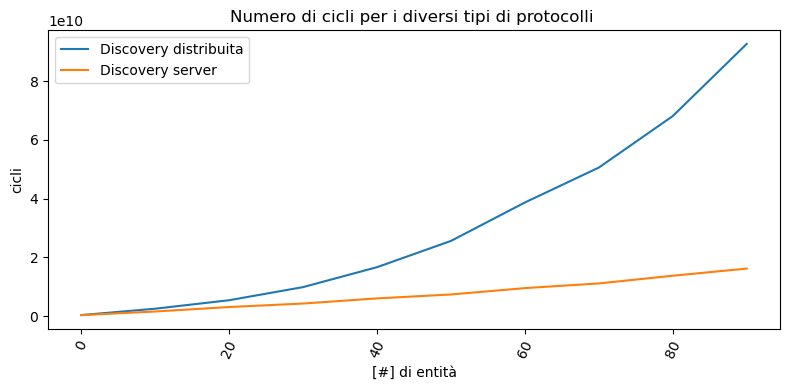

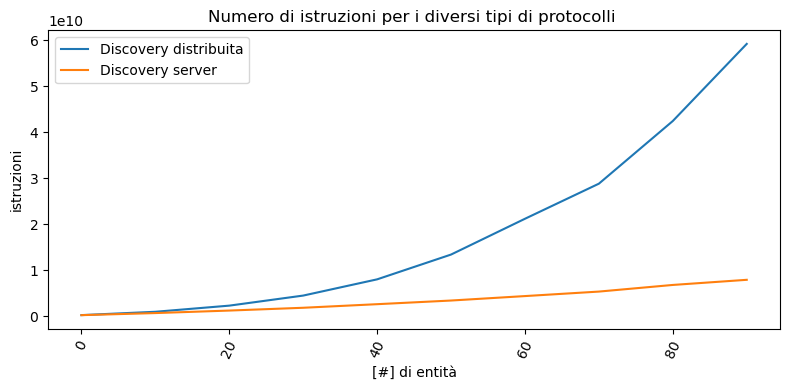

In [19]:
discovery_files = []
discovery_server_files = []
metric_names = [ 'cycles', 'instructions']
metric_data_discovery = {metric: [] for metric in metric_names}
metric_data_discovery_server = {metric: [] for metric in metric_names}
try:
    ranges=os.environ['RANG']
    granularity=os.environ['GRAN']
except:
    ranges=91
    granularity=10
# Find all files in the 'perf' folder
for X in range(1, ranges + 1, granularity):
    simple_file = f'data/discovery/data/discovery_{X}.data'
    server_file = f'data/discovery/data/discovery_server_{X}.data'
    discovery_server_files.append(server_file)    
    discovery_files.append(simple_file)
# Extract data from 'discovery' files
for file_path in discovery_files:
    data = extract_data_from_file(file_path)
    for i, metric in enumerate(metric_names):
        metric_data_discovery[metric].append(data[i])
# Extract data from 'discovery_server' files
for file_path in discovery_server_files:
    data = extract_data_from_file(file_path)
    for i, metric in enumerate(metric_names):
        metric_data_discovery_server[metric].append(data[i])

# Create a summary graph comparing 'discovery' and 'discovery_server' for each metric
x_labels = range(0,91,10)
x_labels_server = [f'{i*1}' for i in range(1, len(discovery_server_files) + 1)]
print(metric_data_discovery["cycles"])
for metric in metric_names:
    plt.figure(figsize=(8,4))
    plt.plot(x_labels, metric_data_discovery[metric], label='Discovery distribuita')
    plt.plot(x_labels, metric_data_discovery_server[metric], label='Discovery server')
    plt.xlabel('[#] di entità')
    name=metric.replace('cycles','cicli').replace('instructions','istruzioni')
    plt.ylabel(name)
    plt.title(f'Numero di {name} per i diversi tipi di protocolli ')
    plt.legend()
    plt.xticks(rotation=65)
    plt.tight_layout()

    plt.savefig(f'../latex/results/test0_{name}.png')



ENV NOT FOUND
Processing data/discovery/save_pcapng/discovery_server_1.pcapng
Processing data/discovery/save_pcapng/simple_1.pcapng
Processing data/discovery/save_pcapng/discovery_server_11.pcapng
Processing data/discovery/save_pcapng/simple_11.pcapng
Processing data/discovery/save_pcapng/discovery_server_21.pcapng
Processing data/discovery/save_pcapng/simple_21.pcapng
Processing data/discovery/save_pcapng/discovery_server_31.pcapng
Processing data/discovery/save_pcapng/simple_31.pcapng
Processing data/discovery/save_pcapng/discovery_server_41.pcapng
Processing data/discovery/save_pcapng/simple_41.pcapng
Processing data/discovery/save_pcapng/discovery_server_51.pcapng
Processing data/discovery/save_pcapng/simple_51.pcapng
Processing data/discovery/save_pcapng/discovery_server_61.pcapng
Processing data/discovery/save_pcapng/simple_61.pcapng
Processing data/discovery/save_pcapng/discovery_server_71.pcapng
Processing data/discovery/save_pcapng/simple_71.pcapng
Processing data/discovery/sa

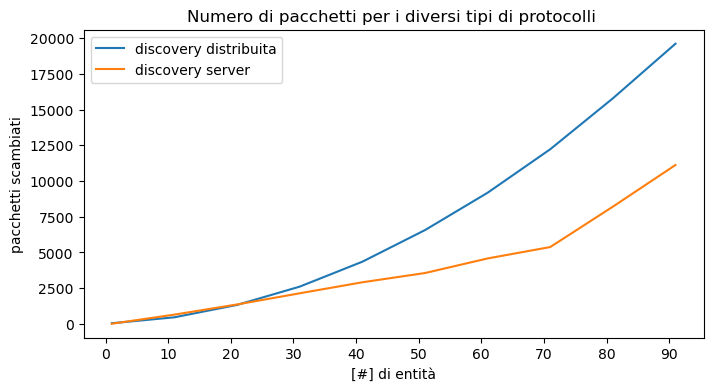

In [36]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import os
def plot_packets(data,prot1,prot2):
    x_values = [first[0] for first in data]
    protc1 = [first[1] for first in data]
    protc2 = [first[2] for first in data]
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(4)
    ax.plot(x_values, protc2, label="discovery distribuita")
    ax.plot(x_values, protc1, label="discovery server")
    ax.set_xlabel('[#] di entità')
    ax.set_ylabel('pacchetti scambiati')
    ax.set_xticks(range(0,91,10))
    plt.title(f'Numero di pacchetti per i diversi tipi di protocolli ')

    ax.legend()
    plt.savefig(f'../latex/results//test0_packet.png')
    plt.show()

def count_packets(filename):
    print('Processing {}'.format(filename))
    command = 'tshark -r {} -Y'.format(filename)
    command += ' "rtps && ('
    command += ' (rtps.sm.rdEntityId == 0x000002c2) ||'
    command += ' (rtps.sm.rdEntityId == 0x000002c7) ||'
    command += ' (rtps.sm.rdEntityId == 0x000003c2) ||'
    command += ' (rtps.sm.rdEntityId == 0x000003c7) ||'
    command += ' (rtps.sm.rdEntityId == 0x000004c2) ||'
    command += ' (rtps.sm.rdEntityId == 0x000004c7) ||'
    command += ' (rtps.sm.rdEntityId == 0x000100c2) ||'
    command += ' (rtps.sm.rdEntityId == 0x000100c7) ||'
    command += ' (rtps.sm.rdEntityId == 0x000200C2) ||'
    command += ' (rtps.sm.rdEntityId == 0x000200C7) ||'
    command += ' (rtps.sm.rdEntityId == 0x000201C3) ||'
    command += ' (rtps.sm.rdEntityId == 0x000201C4))" | wc -l'

    res = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    n_packets = int(res.communicate()[0].decode().rstrip())
    return n_packets

if __name__ == '__main__':
    data = []
    try:
        ranges=int(os.environ['RANG'])
        granularity=int(os.environ['GRAN'])
        prot1=os.environ['PROT1']
        prot2=os.environ['PROT2']
        print(type(ranges),type(granularity))
    except:
        print("ENV NOT FOUND")
        prot1="discovery_server"
        prot2="simple"
        ranges=91
        granularity=10

    for X in range(1, ranges + 1, granularity):
        prot1_file = f'data/discovery/save_pcapng/{prot1}_{X}.pcapng'
        prot2_file = f'data/discovery/save_pcapng/{prot2}_{X}.pcapng'
        if not os.path.isfile(prot1_file) or not os.path.isfile(prot2_file):
            print(f'Cannot find files {prot1_file} or {prot2_file}')
            continue

        prot_c1 =  count_packets(prot1_file)
        prot_c2 = count_packets(prot2_file)
        data.append([X,prot_c1,prot_c2])

    print(data)
    plot_packets(data,prot1=prot1,prot2=prot2)
